<a href="https://colab.research.google.com/github/caiobaptistaa/Econometria-4_PUC-Rio/blob/main/LSTM_Recurrent_Neural_Net_Bayesian_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 2.8 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pandas import concat
pd.pandas.set_option('display.max_columns', None)
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args
from tensorflow import keras


def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Trabalho-1/data.csv', sep= ",", low_memory= False)
CPI = pd.read_csv('/content/drive/MyDrive/Trabalho-1/CPI.csv', sep= ",", low_memory= False)

Mounted at /content/drive


In [4]:
CPI.shape, df.shape

((758, 3), (759, 104))

In [5]:
CPI.head()

,sasdate,CPIAUCSL,CPIAUCSL_diff
0,1959-03-01,-0.001036,-0.000691
1,1959-04-01,0.000345,0.001381
2,1959-05-01,0.002066,0.001721
3,1959-06-01,0.002405,0.000339
4,1959-07-01,0.001372,-0.001032


In [6]:
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,AMDMNOx,AMDMUOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,S&P 500,S&P: indust,FEDFUNDS,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
0,1959-02-01,0.003931,0.003613,0.010368,0.007310,0.019395,0.013404,0.008623,0.007310,0.005233,0.009513,0.013292,0.031178,0.045032,0.017354,0.018214,-0.002727,-0.013714,1.2455,-0.004234,-0.002885,-0.1,-0.8,-0.012788,-0.004286,-0.089097,-0.086094,-0.091328,-0.028293,0.003994,0.004989,-0.012419,-0.004353,0.007771,0.011264,0.002872,0.003438,0.003891,0.002605,0.005777,0.000827,0.001356,39.7,0.1,40.3,7.418781,5.846439,6.150603,6.230481,5.840642,0.045416,0.024493,0.000013,0.000015,0.004242,0.000195,0.000256,-3049.010875,4.064649e-08,0.000146,-0.015400,-0.016493,-0.05,-0.12,0.04,0.18,-0.05,-0.06,0.02,0.02,0.27,0.70,1.11,1.53,1.53,1.71,2.46,0.000255,0.0,0.000997,0.007930,0.000009,0.000000,0.000011,0.000040,0.000000,0.000000,0.000005,0.000012,0.000022,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000,8.734933e-07,3.359517e-07,1.547478e-07,0.000002,0.000022,0.000017,0.000024,0.000065
1,1959-03-01,0.006430,0.007359,0.009410,0.008321,0.014303,0.006036,0.004899,0.000000,0.019397,-0.004745,0.010744,0.025639,0.038644,0.014912,0.015524,0.006802,0.024999,1.0341,0.006175,0.009113,-0.3,-0.2,-0.063081,-0.062936,-0.053893,-0.027909,-0.073688,-0.083287,0.006168,0.009431,-0.000142,0.011013,0.009482,0.014154,0.002864,0.004340,0.005256,0.003489,0.009304,0.004124,0.001969,40.0,0.2,40.4,7.390181,5.799093,6.023448,6.220590,5.924256,0.022166,0.024973,0.000005,0.000027,0.006230,0.000004,0.000117,-0.005645,6.502958e-06,0.000059,0.025062,0.024722,0.37,0.10,0.00,0.07,0.03,0.03,-0.01,-0.04,0.00,0.33,0.81,1.19,1.19,1.33,2.05,0.002200,0.0,0.001210,-0.005142,0.000000,0.000009,0.000000,0.000010,0.000101,0.000150,0.000000,0.000046,0.000022,0.000009,0.000027,0.000000,0.000000,0.000000,0.000000,4.689852e-07,1.552290e-06,5.339021e-07,0.000003,0.000022,0.000017,0.000094,0.000522
2,1959-04-01,0.006494,0.007049,-0.003639,0.000616,0.021077,0.014338,0.014542,0.015653,0.006379,0.016511,0.025790,0.027244,0.029658,0.030501,0.021101,0.004054,-0.004499,1.5153,0.003973,0.007765,-0.4,-0.4,0.023706,-0.157205,-0.152362,-0.261610,-0.074787,-0.055003,0.005774,0.010434,0.001561,0.023615,0.008224,0.012416,0.002222,0.003147,0.002939,0.004825,-0.006687,0.003697,0.001229,40.2,0.1,40.5,7.371489,5.616771,5.968708,6.284134,5.961005,0.010990,0.016414,0.000000,0.000010,0.002701,0.000064,0.000262,0.027813,1.464372e-04,0.000142,0.016599,0.018723,0.16,0.15,0.14,0.11,0.13,0.13,0.10,0.01,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,-0.000046,0.0,0.001350,-0.006414,0.000000,0.000009,0.000000,0.000040,0.000000,0.000037,0.000005,0.000011,0.000000,0.000000,0.000000,0.000019,0.000012,0.000000,0.000000,3.958331e-06,1.033545e-06,3.823042e-07,0.000012,0.000022,0.000066,0.000023,0.000004
3,1959-05-01,0.005763,0.006616,0.012005,0.007803,0.014950,0.008269,0.009583,0.004768,0.020151,0.000000,0.031893,0.025433,0.034046,0.008942,0.013828,0.014735,-0.019350,0.9237,-0.002359,-0.001066,-0.1,-0.2,-0.010091,0.073266,-0.073886,-0.045120,-0.092936,0.002185,0.004286,0.005641,0.006784,0.000648,0.006608,0.009102,0.003008,0.003518,0.004027,0.004035,0.011224,0.003275,0.001350,40.3,0.0,40.7,7.311886,5.560682,5.872118,6.188264,5.981414,-0.043038,-0.003043,

In [7]:
df = df.drop([0], axis = 0)
df.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,AMDMNOx,AMDMUOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,S&P 500,S&P: indust,FEDFUNDS,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
1,1959-03-01,0.006430,0.007359,0.009410,0.008321,0.014303,0.006036,0.004899,0.000000,0.019397,-0.004745,0.010744,0.025639,0.038644,0.014912,0.015524,0.006802,0.024999,1.0341,0.006175,0.009113,-0.3,-0.2,-0.063081,-0.062936,-0.053893,-0.027909,-0.073688,-0.083287,0.006168,0.009431,-0.000142,0.011013,0.009482,0.014154,0.002864,0.004340,0.005256,0.003489,0.009304,0.004124,0.001969,40.0,0.2,40.4,7.390181,5.799093,6.023448,6.220590,5.924256,0.022166,0.024973,0.000005,0.000027,0.006230,0.000004,0.000117,-0.005645,0.000007,0.000059,0.025062,0.024722,0.37,0.10,0.00,0.07,0.03,0.03,-0.01,-0.04,0.00,0.33,0.81,1.19,1.19,1.33,2.05,0.002200,0.0,0.001210,-0.005142,0.000000,0.000009,0.000000,0.000010,0.000101,0.000150,0.000000,0.000046,0.000022,0.000009,0.000027,0.000000,0.000000,0.000000,0.000000,4.689852e-07,1.552290e-06,5.339021e-07,0.000003,0.000022,0.000017,0.000094,0.000522
2,1959-04-01,0.006494,0.007049,-0.003639,0.000616,0.021077,0.014338,0.014542,0.015653,0.006379,0.016511,0.025790,0.027244,0.029658,0.030501,0.021101,0.004054,-0.004499,1.5153,0.003973,0.007765,-0.4,-0.4,0.023706,-0.157205,-0.152362,-0.261610,-0.074787,-0.055003,0.005774,0.010434,0.001561,0.023615,0.008224,0.012416,0.002222,0.003147,0.002939,0.004825,-0.006687,0.003697,0.001229,40.2,0.1,40.5,7.371489,5.616771,5.968708,6.284134,5.961005,0.010990,0.016414,0.000000,0.000010,0.002701,0.000064,0.000262,0.027813,0.000146,0.000142,0.016599,0.018723,0.16,0.15,0.14,0.11,0.13,0.13,0.10,0.01,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,-0.000046,0.0,0.001350,-0.006414,0.000000,0.000009,0.000000,0.000040,0.000000,0.000037,0.000005,0.000011,0.000000,0.000000,0.000000,0.000019,0.000012,0.000000,0.000000,3.958331e-06,1.033545e-06,3.823042e-07,0.000012,0.000022,0.000066,0.000023,0.000004
3,1959-05-01,0.005763,0.006616,0.012005,0.007803,0.014950,0.008269,0.009583,0.004768,0.020151,0.000000,0.031893,0.025433,0.034046,0.008942,0.013828,0.014735,-0.019350,0.9237,-0.002359,-0.001066,-0.1,-0.2,-0.010091,0.073266,-0.073886,-0.045120,-0.092936,0.002185,0.004286,0.005641,0.006784,0.000648,0.006608,0.009102,0.003008,0.003518,0.004027,0.004035,0.011224,0.003275,0.001350,40.3,0.0,40.7,7.311886,5.560682,5.872118,6.188264,5.981414,-0.043038,-0.003043,0.000051,0.000052,0.005181,0.000000,0.000029,-0.022349,0.000434,0.000128,0.014949,0.019023,-0.06,-0.11,0.06,0.24,0.23,0.19,0.14,0.10,-0.06,0.43,1.06,1.45,1.41,1.47,2.06,0.000046,0.0,-0.000710,-0.000623,0.000009,0.000009,0.000042,0.000040,0.000000,0.000037,0.000005,0.000000,0.000022,0.000009,0.000007,0.000019,0.000012,0.000000,0.000000,3.123134e-07,2.765394e-06,1.141107e-06,0.000002,0.000021,0.000016,0.000000,0.000176
4,1959-06-01,0.003102,0.002974,0.003708,0.009064,0.001144,0.007034,0.007126,-0.004768,0.007452,-0.007044,0.023273,-0.006575,-0.007350,-0.003002,0.001142,0.005308,0.000000,-0.1473,0.001466,0.002316,-0.1,0.2,0.028659,-0.042689,-0.002075,0.062132,-0.048095,0.044765,0.002443,0.004325,0.007018,0.004202,0.004317,0.005335,0.002841,0.001374,0.001734,0.002834,0.002105,0.002857,-0.001227,40.2,0.0,40.6,7.315218,5.537334,5.837730,6.249975,5.961005,0.045693,0.007621,0.000013,0.000042,0

In [8]:
np.random.seed(7)

In [9]:
date = df["sasdate"]
date = pd.DataFrame(date)
date

,sasdate
1,1959-03-01
2,1959-04-01
3,1959-05-01
4,1959-06-01
5,1959-07-01
...,...
754,2021-12-01
755,2022-01-01
756,2022-02-01
757,2022-03-01


In [10]:
check_stationarity(CPI["CPIAUCSL_diff"])

ADF Statistic: -11.333683
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Stationary


In [11]:
CPI = CPI.drop(columns = "CPIAUCSL")

In [12]:
CPI.head()

,sasdate,CPIAUCSL_diff
0,1959-03-01,-0.000691
1,1959-04-01,0.001381
2,1959-05-01,0.001721
3,1959-06-01,0.000339
4,1959-07-01,-0.001032


In [13]:
CPI.index = pd.DatetimeIndex(CPI["sasdate"])
CPI = CPI.drop(columns = ["sasdate"])

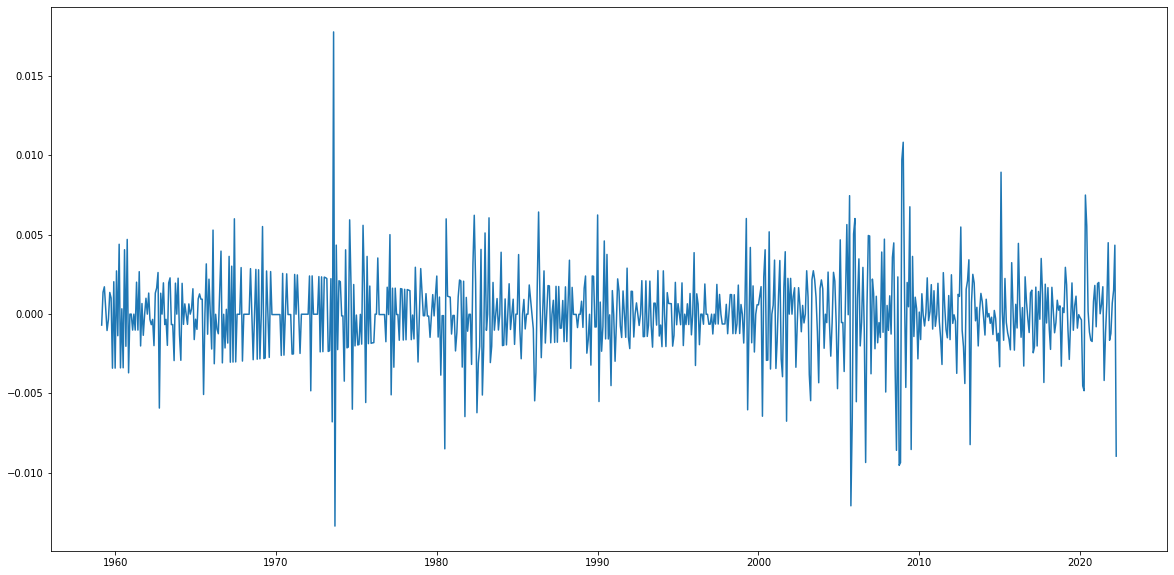

In [14]:
CPI_ts = pd.Series(CPI["CPIAUCSL_diff"].values, index = CPI.index)
plt.figure(figsize= (20, 10))
plt.plot(CPI_ts)

In [15]:
CPI = CPI.reset_index(drop= True)
CPI.head()

,CPIAUCSL_diff
0,-0.000691
1,0.001381
2,0.001721
3,0.000339
4,-0.001032


In [16]:
df = df.drop(columns = ["sasdate"]).astype(float)
df = df.reset_index(drop=True)

In [17]:
data = pd.merge(CPI, df, left_index = True, right_index = True)

In [18]:
data.head()

,CPIAUCSL_diff,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,AMDMNOx,AMDMUOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,S&P 500,S&P: indust,FEDFUNDS,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
0,-0.000691,0.006430,0.007359,0.009410,0.008321,0.014303,0.006036,0.004899,0.000000,0.019397,-0.004745,0.010744,0.025639,0.038644,0.014912,0.015524,0.006802,0.024999,1.0341,0.006175,0.009113,-0.3,-0.2,-0.063081,-0.062936,-0.053893,-0.027909,-0.073688,-0.083287,0.006168,0.009431,-0.000142,0.011013,0.009482,0.014154,0.002864,0.004340,0.005256,0.003489,0.009304,0.004124,0.001969,40.0,0.2,40.4,7.390181,5.799093,6.023448,6.220590,5.924256,0.022166,0.024973,0.000005,0.000027,0.006230,0.000004,0.000117,-0.005645,0.000007,0.000059,0.025062,0.024722,0.37,0.10,0.00,0.07,0.03,0.03,-0.01,-0.04,0.00,0.33,0.81,1.19,1.19,1.33,2.05,0.002200,0.0,0.001210,-0.005142,0.000000,0.000009,0.000000,0.000010,0.000101,0.000150,0.000000,0.000046,0.000022,0.000009,0.000027,0.000000,0.000000,0.000000,0.000000,4.689852e-07,1.552290e-06,5.339021e-07,0.000003,0.000022,0.000017,0.000094,0.000522
1,0.001381,0.006494,0.007049,-0.003639,0.000616,0.021077,0.014338,0.014542,0.015653,0.006379,0.016511,0.025790,0.027244,0.029658,0.030501,0.021101,0.004054,-0.004499,1.5153,0.003973,0.007765,-0.4,-0.4,0.023706,-0.157205,-0.152362,-0.261610,-0.074787,-0.055003,0.005774,0.010434,0.001561,0.023615,0.008224,0.012416,0.002222,0.003147,0.002939,0.004825,-0.006687,0.003697,0.001229,40.2,0.1,40.5,7.371489,5.616771,5.968708,6.284134,5.961005,0.010990,0.016414,0.000000,0.000010,0.002701,0.000064,0.000262,0.027813,0.000146,0.000142,0.016599,0.018723,0.16,0.15,0.14,0.11,0.13,0.13,0.10,0.01,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,-0.000046,0.0,0.001350,-0.006414,0.000000,0.000009,0.000000,0.000040,0.000000,0.000037,0.000005,0.000011,0.000000,0.000000,0.000000,0.000019,0.000012,0.000000,0.000000,3.958331e-06,1.033545e-06,3.823042e-07,0.000012,0.000022,0.000066,0.000023,0.000004
2,0.001721,0.005763,0.006616,0.012005,0.007803,0.014950,0.008269,0.009583,0.004768,0.020151,0.000000,0.031893,0.025433,0.034046,0.008942,0.013828,0.014735,-0.019350,0.9237,-0.002359,-0.001066,-0.1,-0.2,-0.010091,0.073266,-0.073886,-0.045120,-0.092936,0.002185,0.004286,0.005641,0.006784,0.000648,0.006608,0.009102,0.003008,0.003518,0.004027,0.004035,0.011224,0.003275,0.001350,40.3,0.0,40.7,7.311886,5.560682,5.872118,6.188264,5.981414,-0.043038,-0.003043,0.000051,0.000052,0.005181,0.000000,0.000029,-0.022349,0.000434,0.000128,0.014949,0.019023,-0.06,-0.11,0.06,0.24,0.23,0.19,0.14,0.10,-0.06,0.43,1.06,1.45,1.41,1.47,2.06,0.000046,0.0,-0.000710,-0.000623,0.000009,0.000009,0.000042,0.000040,0.000000,0.000037,0.000005,0.000000,0.000022,0.000009,0.000007,0.000019,0.000012,0.000000,0.000000,3.123134e-07,2.765394e-06,1.141107e-06,0.000002,0.000021,0.000016,0.000000,0.000176
3,0.000339,0.003102,0.002974,0.003708,0.009064,0.001144,0.007034,0.007126,-0.004768,0.007452,-0.007044,0.023273,-0.006575,-0.007350,-0.003002,0.001142,0.005308,0.000000,-0.1473,0.001466,0.002316,-0.1,0.2,0.028659,-0.042689,-0.002075,0.062132,-0.048095,0.044765,0.002443,0.004325,0.007018,0.004202,0.004317,0.005335,0.002841,0.001374,0.001734,0.002834,0.002105,0.002857,-0.001227,40.2,0.0,40.6,7.315218,5.537334,5.837730,6.249975,5.961005,0.045693,0.007621,0.000013,0.000042,0.

In [19]:
date = pd.to_datetime(date['sasdate'])

In [20]:
scaler = StandardScaler()

In [21]:
scaler.fit(data)

StandardScaler()

In [22]:
data_scaled = scaler.transform(data)

In [23]:
data_new = pd.DataFrame(data_scaled, columns = data.columns)

In [24]:
data_new.head()

,CPIAUCSL_diff,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,AMDMNOx,AMDMUOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,S&P 500,S&P: indust,FEDFUNDS,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
0,-0.258455,0.314234,0.805635,0.795215,0.225251,1.209486,0.410781,0.264025,-0.147296,0.526428,-0.780462,0.428831,1.889584,1.935162,1.130419,1.165149,0.126700,1.121698,1.226616,1.597723,1.176346,-0.682465,-0.260630,-0.672248,-0.726161,-0.837002,-0.285682,-1.009985,-0.729554,0.800798,1.413802,0.007814,0.909844,1.586467,1.849462,0.715246,0.428734,0.770864,0.685134,1.180329,1.076344,0.188682,-0.447444,1.386253,-0.514840,0.540183,1.772599,1.143173,-0.646305,0.373623,0.459618,1.953237,-0.037990,-0.146774,0.630042,-0.142629,-0.083112,-0.005634,-0.186708,-0.179988,0.539593,0.518256,0.741546,0.246867,0.006398,0.176536,0.100009,0.115715,-0.043692,-0.187701,0.622737,0.833515,0.987239,0.347742,0.085102,-0.383359,-0.504899,0.171580,0.059306,0.104873,-0.410615,-0.443842,-0.357939,-0.347650,-0.332156,-0.198852,-0.344024,-0.329840,-0.151823,-0.132988,-0.252565,0.110346,-0.581824,-0.569546,-0.481065,-0.566437,-0.612670,-0.400015,-0.327453,-0.612286,0.021427,-0.265092,1.637172,1.843812
1,0.511228,0.319495,0.754886,-0.733418,-0.262123,1.877677,1.246843,1.153510,1.329104,0.125134,1.968020,1.293660,2.018751,1.450659,2.450177,1.648507,0.049543,-0.275768,1.795779,0.895179,0.976026,-0.912277,-0.505890,0.245723,-1.806399,-2.349077,-2.676669,-1.024864,-0.480104,0.734729,1.566281,0.100761,2.083104,1.380841,1.624622,0.572188,0.228921,0.320615,1.065196,-1.216103,0.884878,-0.028746,-0.139534,0.686200,-0.379712,0.479118,1.333356,1.011155,-0.434722,0.472556,0.180613,1.145918,-0.038076,-0.247717,0.004879,-0.125066,-0.080437,0.028201,0.012914,0.448478,0.302721,0.350975,0.323796,0.367221,0.363719,0.274372,0.416928,0.481947,0.462283,0.048719,0.608414,0.806944,0.921211,0.325060,0.066234,-0.414963,-0.579960,0.079879,0.059306,0.111476,-0.505792,-0.443842,-0.357939,-0.347650,-0.322547,-0.201759,-0.399633,-0.260114,-0.218155,-0.827994,-0.346459,-0.294716,-0.071696,-0.238570,-0.481065,-0.566437,-0.445791,-0.417823,-0.328716,-0.121285,0.015622,0.215160,-0.006646,-0.559033
2,0.637727,0.259402,0.684295,1.099226,0.192500,1.273368,0.635670,0.696060,0.302460,0.549678,-0.166921,1.644465,1.873019,1.687253,0.624966,1.018137,0.349425,-0.979330,1.096035,-1.125777,-0.336784,-0.222839,-0.260630,-0.111756,0.834598,-1.144008,-0.461773,-1.270512,0.024252,0.485148,0.837162,0.385783,-0.055104,1.116842,1.196182,0.747230,0.291010,0.532001,0.840572,1.468126,0.695501,0.006826,0.014421,-0.013853,-0.109457,0.284405,1.198227,0.778206,-0.753942,0.527499,-1.168171,-0.689173,-0.037138,-0.001740,0.444287,-0.143807,-0.084741,-0.022526,0.422741,0.344149,0.256528,0.359349,-0.113846,-0.258617,0.159536,0.592337,0.733846,0.701685,0.646274,0.474275,0.536798,0.966373,1.317382,0.544321,0.223462,-0.309617,-0.499895,0.083656,0.059306,0.014703,-0.072207,-0.351317,-0.357939,-0.143755,-0.322547,-0.201759,-0.399633,-0.260424,-0.239970,-0.139484,-0.252565,-0.194241,-0.076094,-0.240845,-0.481065,-0.566437,-0.620163,-0.358372,-0.322394,-0.644980,0.009896,-0.267683,-0.544103,0.237623
3,0.124012,0.040680,0.089311,0.127303,0.272255,-0.088274,0.511322,0.469459,-0.597052,0.158196,-1.077679,1.148946,-0.702212,-0.544738,-0.386205,-0.081499

In [25]:
data_new.isnull().values.any()

False

In [26]:
data_new.shape

(758, 104)

In [27]:
data_new = data_new.astype(float)

In [28]:
data_new.head()

,CPIAUCSL_diff,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,AMDMNOx,AMDMUOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,S&P 500,S&P: indust,FEDFUNDS,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
0,-0.258455,0.314234,0.805635,0.795215,0.225251,1.209486,0.410781,0.264025,-0.147296,0.526428,-0.780462,0.428831,1.889584,1.935162,1.130419,1.165149,0.126700,1.121698,1.226616,1.597723,1.176346,-0.682465,-0.260630,-0.672248,-0.726161,-0.837002,-0.285682,-1.009985,-0.729554,0.800798,1.413802,0.007814,0.909844,1.586467,1.849462,0.715246,0.428734,0.770864,0.685134,1.180329,1.076344,0.188682,-0.447444,1.386253,-0.514840,0.540183,1.772599,1.143173,-0.646305,0.373623,0.459618,1.953237,-0.037990,-0.146774,0.630042,-0.142629,-0.083112,-0.005634,-0.186708,-0.179988,0.539593,0.518256,0.741546,0.246867,0.006398,0.176536,0.100009,0.115715,-0.043692,-0.187701,0.622737,0.833515,0.987239,0.347742,0.085102,-0.383359,-0.504899,0.171580,0.059306,0.104873,-0.410615,-0.443842,-0.357939,-0.347650,-0.332156,-0.198852,-0.344024,-0.329840,-0.151823,-0.132988,-0.252565,0.110346,-0.581824,-0.569546,-0.481065,-0.566437,-0.612670,-0.400015,-0.327453,-0.612286,0.021427,-0.265092,1.637172,1.843812
1,0.511228,0.319495,0.754886,-0.733418,-0.262123,1.877677,1.246843,1.153510,1.329104,0.125134,1.968020,1.293660,2.018751,1.450659,2.450177,1.648507,0.049543,-0.275768,1.795779,0.895179,0.976026,-0.912277,-0.505890,0.245723,-1.806399,-2.349077,-2.676669,-1.024864,-0.480104,0.734729,1.566281,0.100761,2.083104,1.380841,1.624622,0.572188,0.228921,0.320615,1.065196,-1.216103,0.884878,-0.028746,-0.139534,0.686200,-0.379712,0.479118,1.333356,1.011155,-0.434722,0.472556,0.180613,1.145918,-0.038076,-0.247717,0.004879,-0.125066,-0.080437,0.028201,0.012914,0.448478,0.302721,0.350975,0.323796,0.367221,0.363719,0.274372,0.416928,0.481947,0.462283,0.048719,0.608414,0.806944,0.921211,0.325060,0.066234,-0.414963,-0.579960,0.079879,0.059306,0.111476,-0.505792,-0.443842,-0.357939,-0.347650,-0.322547,-0.201759,-0.399633,-0.260114,-0.218155,-0.827994,-0.346459,-0.294716,-0.071696,-0.238570,-0.481065,-0.566437,-0.445791,-0.417823,-0.328716,-0.121285,0.015622,0.215160,-0.006646,-0.559033
2,0.637727,0.259402,0.684295,1.099226,0.192500,1.273368,0.635670,0.696060,0.302460,0.549678,-0.166921,1.644465,1.873019,1.687253,0.624966,1.018137,0.349425,-0.979330,1.096035,-1.125777,-0.336784,-0.222839,-0.260630,-0.111756,0.834598,-1.144008,-0.461773,-1.270512,0.024252,0.485148,0.837162,0.385783,-0.055104,1.116842,1.196182,0.747230,0.291010,0.532001,0.840572,1.468126,0.695501,0.006826,0.014421,-0.013853,-0.109457,0.284405,1.198227,0.778206,-0.753942,0.527499,-1.168171,-0.689173,-0.037138,-0.001740,0.444287,-0.143807,-0.084741,-0.022526,0.422741,0.344149,0.256528,0.359349,-0.113846,-0.258617,0.159536,0.592337,0.733846,0.701685,0.646274,0.474275,0.536798,0.966373,1.317382,0.544321,0.223462,-0.309617,-0.499895,0.083656,0.059306,0.014703,-0.072207,-0.351317,-0.357939,-0.143755,-0.322547,-0.201759,-0.399633,-0.260424,-0.239970,-0.139484,-0.252565,-0.194241,-0.076094,-0.240845,-0.481065,-0.566437,-0.620163,-0.358372,-0.322394,-0.644980,0.009896,-0.267683,-0.544103,0.237623
3,0.124012,0.040680,0.089311,0.127303,0.272255,-0.088274,0.511322,0.469459,-0.597052,0.158196,-1.077679,1.148946,-0.702212,-0.544738,-0.386205,-0.081499

In [29]:
data_new = data_new.to_numpy()

In [30]:
data_new.shape

(758, 104)

In [31]:
train = 492 + 12
test = 758 - train
train, test

(504, 254)

In [32]:
test_lenght = test
train_lenght = len(data_new) - test_lenght

data_train = data_new[0:train_lenght, :]

data_test = data_new[train_lenght:len(data_new), :]
data_train.shape, data_test.shape

((504, 104), (254, 104))

In [33]:
trainX = []
trainY = []

n_future = 1
n_past = 12

for i in range(n_past, len(data_train) - n_future +1):
    trainX.append(data_train[i - n_past:i, 0:data_train.shape[1]])
    trainY.append(data_train[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('X shape == {}.'.format(trainX.shape))
print('Y shape == {}.'.format(trainY.shape))

X shape == (492, 12, 104).
Y shape == (492, 1).


In [34]:
testX = []
testY = []

n_future = 1 
n_past = 12

for i in range(n_past, len(data_test) - n_future +1):
    testX.append(data_test[i - n_past:i, 0:data_test.shape[1]])
    testY.append(data_test[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('X shape == {}.'.format(testX.shape))
print('Y shape == {}.'.format(testY.shape))

X shape == (242, 12, 104).
Y shape == (242, 1).


In [35]:
def create_lstm(
    learning_rate,
    num_dense_nodes_1,
    #num_dense_nodes_2,
    activation,
):
    model = Sequential()
    model.add(LSTM(num_dense_nodes_1, activation = activation, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
    #model.add(LSTM(num_dense_nodes_2, activation = activation, return_sequences= False))
    model.add(Dropout(0.1))
    model.add(Dense(trainY.shape[1]))

    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer="Adam", loss='mse')

    return model

In [36]:
dim_learning_rate = Real(
    low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate',
)

dim_num_dense_nodes_1 = Integer(low=1, high=200, name='num_dense_nodes_1')

#dim_num_dense_nodes_2 = Integer(low=1, high=50, name='num_dense_nodes_2')

dim_batch_size = Integer(low= 1, high = 10, name = "batch_size")

dim_epochs = Integer(low=1, high = 30, name = "epochs")

dim_activation = Categorical(
    categories=['relu', 'tanh'], name='activation',
)

In [37]:
param_grid = [dim_learning_rate,
              dim_num_dense_nodes_1,
              #dim_num_dense_nodes_2,
              dim_batch_size,
              dim_epochs,
              dim_activation]

In [38]:
# starting point for the optimization
best_mse = float(1000000000000000.0)

In [39]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_nodes_1,
    #num_dense_nodes_2,
    batch_size,
    epochs,
    activation,

):
    
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_nodes_1:', num_dense_nodes_1)
    #print('num_dense_nodes_2:', num_dense_nodes_2)
    print('activation:', activation)
    print('batchs:', batch_size)
    print('epochs:', epochs)
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_lstm(learning_rate=learning_rate,
                       num_dense_nodes_1=num_dense_nodes_1,
                       #num_dense_nodes_2=num_dense_nodes_2,
                       activation=activation)

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    # fit the model
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,
                        validation_split=0.1, verbose=1, callbacks= learning_rate_reduction)


    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    mse = history.history["val_loss"][0]

    # Print the classification accuracy.
    print(mse)

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_mse

    # If the classification accuracy of the saved model is improved ...
    if mse < best_mse:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        #model.save(path_best_model)
        
        # Update the classification accuracy.
        best_mse = mse

    # Delete the Keras model with these hyper-parameters from memory.
    #del model

    
    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return mse

In [40]:
default_parameters = [1e-5, 1, 1, 1, 'relu']

objective(x=default_parameters)

learning rate: 1.0e-05
num_dense_nodes_1: 1
activation: relu
batchs: 1
epochs: 1

442/442 [==============================] - 9s 12ms/step - loss: 0.9541 - val_loss: 1.1575 - lr: 0.0010
1.1575392484664917


1.1575392484664917

In [41]:
gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    x0=default_parameters, # the initial parameters to test
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

learning rate: 1.0e-05
num_dense_nodes_1: 1
activation: relu
batchs: 1
epochs: 1

442/442 [==============================] - 6s 12ms/step - loss: 1.0264 - val_loss: 0.8185 - lr: 0.0010
0.818450927734375
learning rate: 2.4e-04
num_dense_nodes_1: 169
activation: tanh
batchs: 9
epochs: 26

Epoch 1/26
50/50 [==============================] - 5s 16ms/step - loss: 0.9746 - val_loss: 0.6390 - lr: 0.0010
Epoch 2/26
50/50 [==============================] - 0s 5ms/step - loss: 0.6631 - val_loss: 0.5654 - lr: 0.0010
Epoch 3/26
50/50 [==============================] - 0s 5ms/step - loss: 0.5435 - val_loss: 0.5080 - lr: 0.0010
Epoch 4/26
50/50 [==============================] - 0s 5ms/step - loss: 0.4339 - val_loss: 0.4909 - lr: 0.0010
Epoch 5/26
50/50 [==============================] - 0s 5ms/step - loss: 0.3538 - val_loss: 0.4944 - lr: 0.0010
Epoch 6/26
38/50 [=====================>........] - ETA: 0s - loss: 0.2730
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50

In [42]:
"Best score=%.4f" % gp_.fun

'Best score=0.5065'

In [43]:
gp_.x

[1.0339807922177338e-06, 123, 1, 9, 'tanh']

In [44]:
best_params = dict(list(zip(["learning_rate", "num_dense_nodes_1", "batchs", "epochs",
                             "activation"], gp_.x)))

print("Best Parameters : {}".format(best_params))
print("Best MSE : {}".format(gp_.fun))

Best Parameters : {'learning_rate': 1.0339807922177338e-06, 'num_dense_nodes_1': 123, 'batchs': 1, 'epochs': 9, 'activation': 'tanh'}
Best MSE : 0.5065374970436096


In [45]:
best_lr = best_params.get("learning_rate")
best_dense_nodes_1 = best_params.get("num_dense_nodes_1")
#best_dense_nodes_2 = best_params.get("num_dense_nodes_2")
best_batchs = best_params.get("batchs")
best_epochs = best_params.get("epochs")
best_activ = best_params.get("activation")

In [46]:
model = Sequential()
model.add(LSTM(best_dense_nodes_1, activation = best_activ, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
#model.add(LSTM(best_dense_nodes_2, activation = best_activ, return_sequences= False))
model.add(Dropout(0.1))
model.add(Dense(trainY.shape[1]))

opt = keras.optimizers.Adam(learning_rate=best_lr)
model.compile(optimizer="Adam", loss='mse')
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 123)               112176    
                                                                 
 dropout_31 (Dropout)        (None, 123)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 124       
                                                                 
Total params: 112,300
Trainable params: 112,300
Non-trainable params: 0
_________________________________________________________________


Epoch 1/9
442/442 [==============================] - 4s 5ms/step - loss: 0.9126 - val_loss: 0.5443
Epoch 2/9
442/442 [==============================] - 2s 4ms/step - loss: 0.5987 - val_loss: 0.5544
Epoch 3/9
442/442 [==============================] - 2s 4ms/step - loss: 0.4517 - val_loss: 0.5587
Epoch 4/9
442/442 [==============================] - 2s 4ms/step - loss: 0.3437 - val_loss: 0.5651
Epoch 5/9
442/442 [==============================] - 2s 4ms/step - loss: 0.2609 - val_loss: 0.5887
Epoch 6/9
442/442 [==============================] - 2s 4ms/step - loss: 0.1782 - val_loss: 0.5688
Epoch 7/9
442/442 [==============================] - 2s 4ms/step - loss: 0.1251 - val_loss: 0.5458
Epoch 8/9
442/442 [==============================] - 2s 4ms/step - loss: 0.0985 - val_loss: 0.6307
Epoch 9/9
442/442 [==============================] - 2s 4ms/step - loss: 0.0943 - val_loss: 0.6272


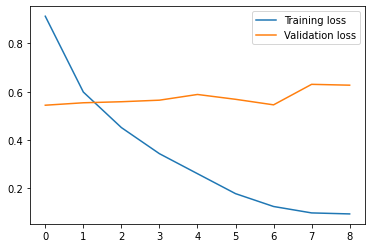

In [47]:
# fit the model
history = model.fit(trainX, trainY, epochs=best_epochs, batch_size=best_batchs, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [48]:
forecast_train = model.predict(trainX)

In [49]:
forecast_train.shape

(492, 1)

In [50]:
forecast_train_copies = np.repeat(forecast_train, data_scaled.shape[1], axis = -1)
forecast_train_copies.shape

(492, 104)

In [51]:
forecast_train_real = scaler.inverse_transform(forecast_train_copies)[:, 0]
forecast_train_real

array([-1.34165131e-03,  3.18025216e-03, -2.49353657e-03, -1.19103387e-03,
       -3.16521130e-03,  3.66235618e-03, -1.08216482e-03,  3.77744180e-03,
       -4.97196941e-03, -7.68095371e-04,  3.12506803e-04, -1.10433437e-03,
        1.61750504e-04, -6.03215070e-04,  1.71091314e-03, -3.50315095e-04,
        2.16959557e-03, -2.72554415e-03,  7.45989499e-04, -1.03554095e-03,
       -3.09320429e-04,  6.13308861e-04, -5.42162561e-05,  1.55529717e-03,
        7.64800934e-04, -1.40995107e-05, -4.54502646e-04, -2.24561780e-03,
        4.92209918e-04,  1.33842940e-03,  2.19510915e-03, -4.58150962e-03,
        1.16420072e-03,  2.62160582e-04,  2.12160381e-03,  6.54594041e-04,
        4.58013965e-04, -9.73790535e-04,  2.04958045e-03,  2.40780483e-03,
       -5.57272055e-04, -3.06802831e-04, -2.36794469e-03,  2.33629346e-03,
       -2.76485545e-04,  1.90577016e-03, -1.01851742e-03, -2.11878610e-03,
        2.17674719e-03, -1.46702572e-04,  2.04633200e-03,  2.30775215e-04,
       -3.45198700e-04,  

In [52]:
trainY_copies =  np.repeat(trainY, data_scaled.shape[1], axis = -1)
trainY_real = scaler.inverse_transform(trainY_copies)[:, 0]

In [53]:
forecast_test = model.predict(testX)

In [54]:
forecast_test_copies =  np.repeat(forecast_test, data_scaled.shape[1], axis = -1)
forecast_test_real = scaler.inverse_transform(forecast_test_copies)[:, 0]

In [55]:
testY_copies =  np.repeat(testY, data_scaled.shape[1], axis = -1)
testY_real = scaler.inverse_transform(testY_copies)[:, 0]

In [56]:
date.shape

(758,)

In [57]:
date_df = pd.DataFrame(date)
date_df.head()

,sasdate
1,1959-03-01
2,1959-04-01
3,1959-05-01
4,1959-06-01
5,1959-07-01


In [58]:
date_train = date_df.iloc[1:492+1, 0]
date_test = date_df.iloc[492+1+1:, 0]

In [59]:
date_test.head()

495   2000-05-01
496   2000-06-01
497   2000-07-01
498   2000-08-01
499   2000-09-01
Name: sasdate, dtype: datetime64[ns]

In [60]:
date_train.head()

2   1959-04-01
3   1959-05-01
4   1959-06-01
5   1959-07-01
6   1959-08-01
Name: sasdate, dtype: datetime64[ns]

In [61]:
date_train = date_train.reset_index(drop=True)
date_test = date_test.reset_index(drop=True)

In [62]:
forecast_train_real = pd.DataFrame(forecast_train_real)
trainY_real = pd.DataFrame(trainY_real)
trainY_real.shape, forecast_train_real.shape, date_train.shape

((492, 1), (492, 1), (492,))

In [63]:
forecast_test_real = pd.DataFrame(forecast_test_real)
testY_real = pd.DataFrame(testY_real)
testY_real.shape, forecast_test_real.shape, date_test.shape

((242, 1), (242, 1), (264,))

In [64]:
comparative_train = pd.merge(forecast_train_real, trainY_real, left_index = True, right_index = True)
comparative_train = comparative_train.rename(columns = {"0_x" : "forecast_train", "0_y" : "trainY"})
comparative_train = pd.merge(date_train, comparative_train, left_index = True, right_index = True)
comparative_train.index = pd.DatetimeIndex(comparative_train["sasdate"])
comparative_train = comparative_train.drop(columns = ["sasdate"])
comparative_train.head()

,forecast_train,trainY
sasdate,,
1959-04-01,-0.001342,-0.001360
1959-05-01,0.003180,0.004401
1959-06-01,-0.002494,-0.003386
1959-07-01,-0.001191,0.000336
1959-08-01,-0.003165,-0.003381


In [65]:
date_test = pd.DataFrame(date_test)

In [66]:
comparative_test = pd.merge(forecast_test_real, testY_real, left_index = True, right_index = True)
comparative_test = comparative_test.rename(columns = {"0_x" : "forecast_test", "0_y" : "testY"})
comparative_test = pd.merge(date_test, comparative_test, left_index = True, right_index = True)
comparative_test.index = pd.DatetimeIndex(comparative_test["sasdate"])
comparative_test = comparative_test.drop(columns = ["sasdate"])
comparative_test.head()

,forecast_test,testY
sasdate,,
2000-05-01,0.000286,0.001116
2000-06-01,-0.001425,0.001661
2000-07-01,-0.001152,-0.003348
2000-08-01,0.000423,-0.000557
2000-09-01,-0.000411,0.001665


In [67]:
date_test.shape, forecast_test_real.shape

((264, 1), (242, 1))

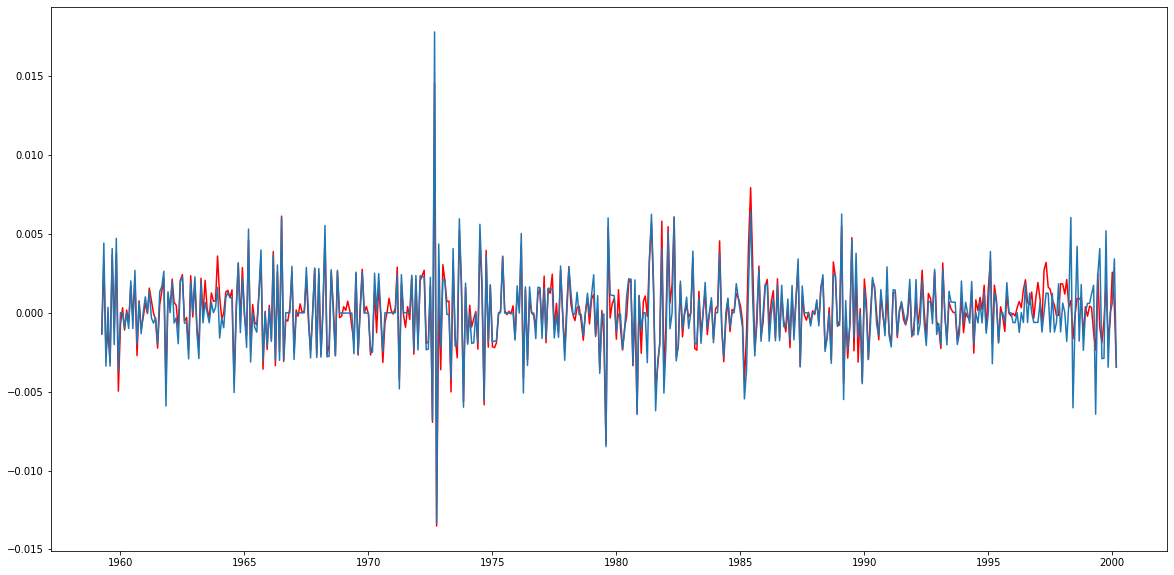

In [68]:
plt.figure(figsize= (20, 10))
plt.plot(comparative_train["forecast_train"], color = "red")
plt.plot(comparative_train["trainY"])
plt.show()

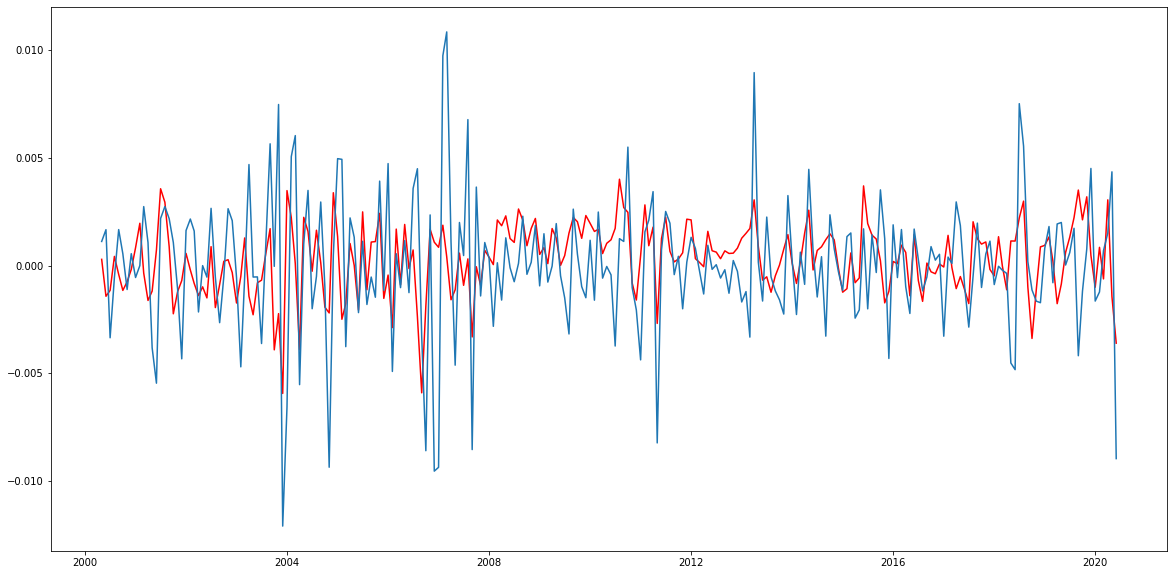

In [69]:
plt.figure(figsize= (20, 10))
plt.plot(comparative_test["forecast_test"], color = "red")
plt.plot(comparative_test["testY"])
plt.show()

In [70]:
mse = mean_squared_error(forecast_test_real, testY_real)
rmse = np.sqrt(mse)
mae = mean_absolute_error(forecast_test_real, testY_real)
print('%f' % mse), print('%f' % mae), print('%f' % rmse)

0.000009
0.002162
0.002979


(None, None, None)